In [106]:
import numpy as np
import pandas as pd
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
!pip install chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 6.2 MB/s eta 0:00:00


# File util

In [107]:
#-*- coding: utf-8 -*-


import os
import chardet

'''
dirname        : path that need to be searched
ret                : files in the dirname (recursive)
list_avoid_dir : dirname need to be skipped
usage           : 
    list_files = []
    file_search(dirname, list_files):   
'''
def file_search(dirname, ret, list_avoid_dir=[]):
    
    filenames = os.listdir(dirname)
    
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)
            
        else:
            ret.append( full_filename )          

            

'''
filename : filename (inc. path) that will be inspected
'''
def find_encoding(filename):
    rawdata = open(filename, 'rb').read()
    result = chardet.detect(rawdata)
    charenc = result['encoding']    
    return charenc
            
'''
dir_name : dir_name (inc. path) that will be created ( full-path name )
'''
def create_folder(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [108]:
df = pd.read_csv("/kaggle/input/emotion-recognition/processed_data.csv")
df.head()

,Unnamed: 0,sessionID,text,label
0,0,Ses01F_impro01_F000,Excuse me.,3
1,1,Ses01F_impro01_F001,Yeah.,3
2,2,Ses01F_impro01_F002,Is there a problem?,3
3,3,Ses01F_impro01_F003,You did.,-1
4,4,Ses01F_impro01_F004,You were standing at the beginning and you dir...,-1


In [109]:
list_files = []
for x in range(5):
    sess_name = 'Session' + str(x+1)
    path = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/'+ sess_name + '/sentences/wav/'
    file_search(path, list_files)
    list_files = sorted(list_files)
    print (sess_name + ", #sum files: " + str(len(list_files)))

Session1, #sum files: 1820
Session2, #sum files: 3633
Session3, #sum files: 5769
Session4, #sum files: 7873
Session5, #sum files: 10043


In [110]:
len(list_files)

10043

In [111]:
df.shape

(10039, 4)

In [112]:
df["path"] = ""

In [113]:
df.head()

,Unnamed: 0,sessionID,text,label,path
0,0,Ses01F_impro01_F000,Excuse me.,3,
1,1,Ses01F_impro01_F001,Yeah.,3,
2,2,Ses01F_impro01_F002,Is there a problem?,3,
3,3,Ses01F_impro01_F003,You did.,-1,
4,4,Ses01F_impro01_F004,You were standing at the beginning and you dir...,-1,


In [114]:
for everyFile in list_files:
  if(everyFile.split('/')[-1].endswith('.wav')):
    filename=everyFile.split('/')[-1].strip('.wav')
    index_session = df[df["sessionID"] == filename].index
    df.loc[index_session, 'path'] = everyFile

In [115]:
df.head()

,Unnamed: 0,sessionID,text,label,path
0,0,Ses01F_impro01_F000,Excuse me.,3,/kaggle/input/iemocapfullrelease/IEMOCAP_full_...
1,1,Ses01F_impro01_F001,Yeah.,3,/kaggle/input/iemocapfullrelease/IEMOCAP_full_...
2,2,Ses01F_impro01_F002,Is there a problem?,3,/kaggle/input/iemocapfullrelease/IEMOCAP_full_...
3,3,Ses01F_impro01_F003,You did.,-1,/kaggle/input/iemocapfullrelease/IEMOCAP_full_...
4,4,Ses01F_impro01_F004,You were standing at the beginning and you dir...,-1,/kaggle/input/iemocapfullrelease/IEMOCAP_full_...


In [116]:
df['path'].replace('', np.nan, inplace=True)
df.dropna(subset=['path'], inplace=True)

In [117]:
df.shape

(10039, 5)

# Augumentation

In [64]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sr=sampling_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
#     return librosa.effects.pitch_shift(data, sr = sampling_rate, pitch_factor=0.7)
    return data

# Features extraction

In [118]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
#     noise_data = noise(data)
#     res2 = extract_features(noise_data, sample_rate)
#     result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
#     new_data = stretch(data)
#     data_stretch_pitch = pitch(new_data, sample_rate)
#     res3 = extract_features(data_stretch_pitch, sample_rate)
#     result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [119]:
df['label'].replace(-1, np.nan, inplace=True)
df.dropna(subset=['label'], inplace=True)
df.shape

(5531, 5)

In [120]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [121]:
print(df["label"][12], df["path"][12], df["text"][12])

0.0 /kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F012.wav That's out of control.


In [122]:
print(df["label"][68], df["path"][68], df["text"][68])

1.0 /kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F000.wav Well Vegas was awesome.


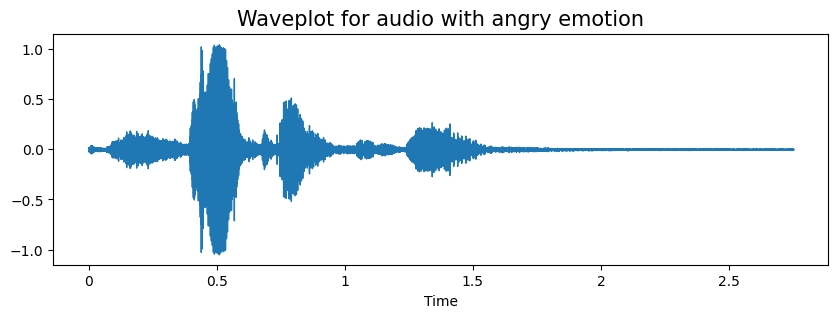

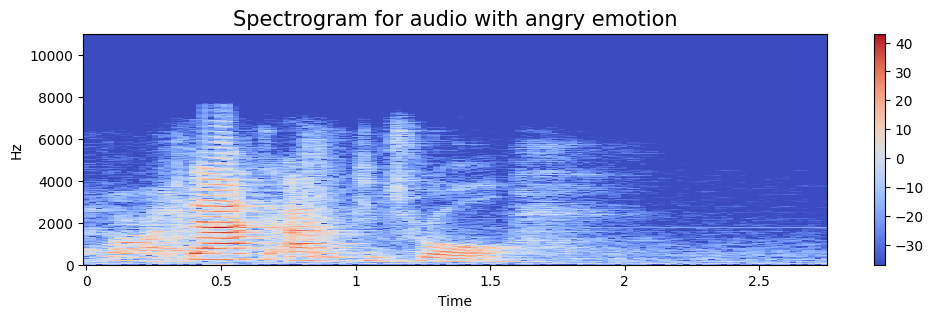

In [123]:
emotion='angry'
path =  df["path"][12]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

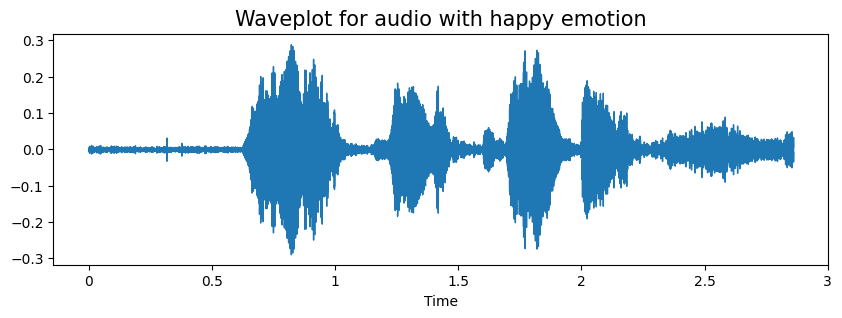

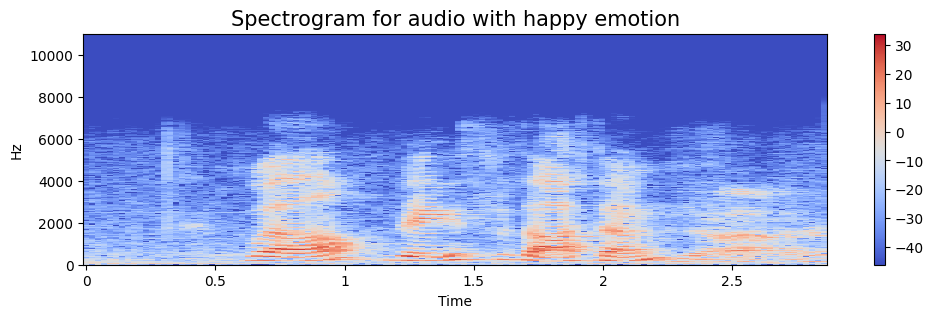

In [124]:
emotion='happy'
path =  df["path"][68]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
X, Y = [], []
for path, emotion in zip(df.path, df.label):
    try:
        feature = get_features(path)
#         for ele in feature:
        X.append(feature)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    except Exception as e:
        print("Error occured")

Error occured


In [126]:
len(X), len(Y), df.path.shape

(895860, 895860, (5531,))

In [71]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('featuresWithoutAugumentation.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.078176,0.766237,0.660930,0.674861,0.699812,0.652369,0.623125,0.623496,0.648030,0.706816,...,5.426504e-09,4.827284e-09,4.400703e-09,4.083973e-09,3.847632e-09,3.674800e-09,3.548793e-09,3.464852e-09,3.413898e-09,3.0
1,0.078403,0.786230,0.708017,0.647941,0.703824,0.662396,0.627340,0.601287,0.617281,0.655602,...,1.547366e-06,1.549690e-06,1.428085e-06,1.499512e-06,1.488012e-06,1.409731e-06,1.442172e-06,1.448363e-06,1.441069e-06,3.0
2,0.092365,0.757630,0.770905,0.769443,0.754734,0.707383,0.598675,0.627702,0.620057,0.636798,...,1.924001e-07,5.319140e-08,2.238493e-08,1.480813e-08,6.742665e-09,4.197424e-09,3.189230e-09,1.976795e-09,5.062582e-10,3.0
3,0.070298,0.804160,0.669910,0.723418,0.703420,0.635514,0.629479,0.695253,0.755410,0.773919,...,6.429178e-06,5.978665e-06,5.659431e-06,5.421914e-06,5.245352e-06,5.119067e-06,5.027465e-06,4.968650e-06,4.932124e-06,3.0
4,0.330452,0.819372,0.787001,0.819178,0.838866,0.833326,0.786869,0.737829,0.783899,0.803591,...,1.601767e-03,1.531628e-03,1.424950e-03,1.444480e-03,1.499497e-03,1.463605e-03,1.393633e-03,1.440792e-03,1.489429e-03,3.0


In [83]:
Features[Features["labels"]==0].shape[0]
Features[Features["labels"]==1].shape[0]
Features[Features["labels"]==2].shape[0]
Features[Features["labels"]==3].shape[0]

5124

In [88]:
Features["labels"][0]

3.0

# Data preparation

In [89]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [91]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [92]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12442, 162), (12442, 4), (4148, 162), (4148, 4))

In [93]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [94]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12442, 162), (12442, 4), (4148, 162), (4148, 4))

In [95]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12442, 162, 1), (12442, 4), (4148, 162, 1), (4148, 4))

# Model

In [96]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

In [97]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
195/195 [==============================] - 15s 13ms/step - loss: 1.2191 - accuracy: 0.4013 - val_loss: 1.1737 - val_accuracy: 0.4441 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - 2s 10ms/step - loss: 1.1625 - accuracy: 0.4382 - val_loss: 1.1330 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - 2s 10ms/step - loss: 1.1454 - accuracy: 0.4578 - val_loss: 1.1242 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 4/50
195/195 [==============================] - 2s 10ms/step - loss: 1.1275 - accuracy: 0.4620 - val_loss: 1.1179 - val_accuracy: 0.4648 - lr: 0.0010
Epoch 5/50
195/195 [==============================] - 2s 10ms/step - loss: 1.1126 - accuracy: 0.4775 - val_loss: 1.1145 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 6/50
195/195 [==============================] - 2s 10ms/step - loss: 1.1101 - accuracy: 0.4882 - val_loss: 1.1323 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 7/50
195/195 [==============================] - 2s 10ms/s

130/130 [==============================] - 1s 5ms/step - loss: 1.3561 - accuracy: 0.5393
Accuracy of our model on test data :  53.929603099823 %


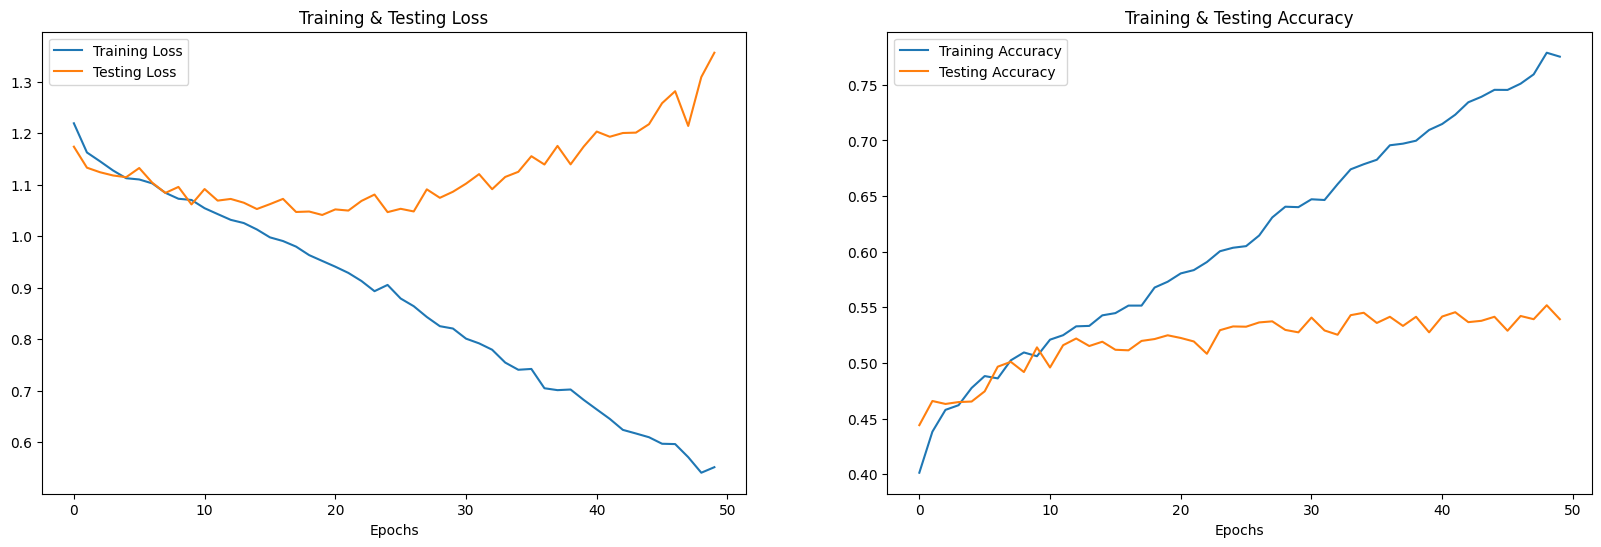

In [98]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [99]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

130/130 [==============================] - 0s 2ms/step


In [100]:
sample_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
sample_df['Predicted Labels'] = y_pred.flatten()
sample_df['Actual Labels'] = y_test.flatten()

sample_df.head(10)

,Predicted Labels,Actual Labels
0,3.0,3.0
1,0.0,0.0
2,3.0,1.0
3,3.0,1.0
4,2.0,2.0
5,1.0,2.0
6,1.0,3.0
7,3.0,2.0
8,3.0,2.0
9,1.0,3.0


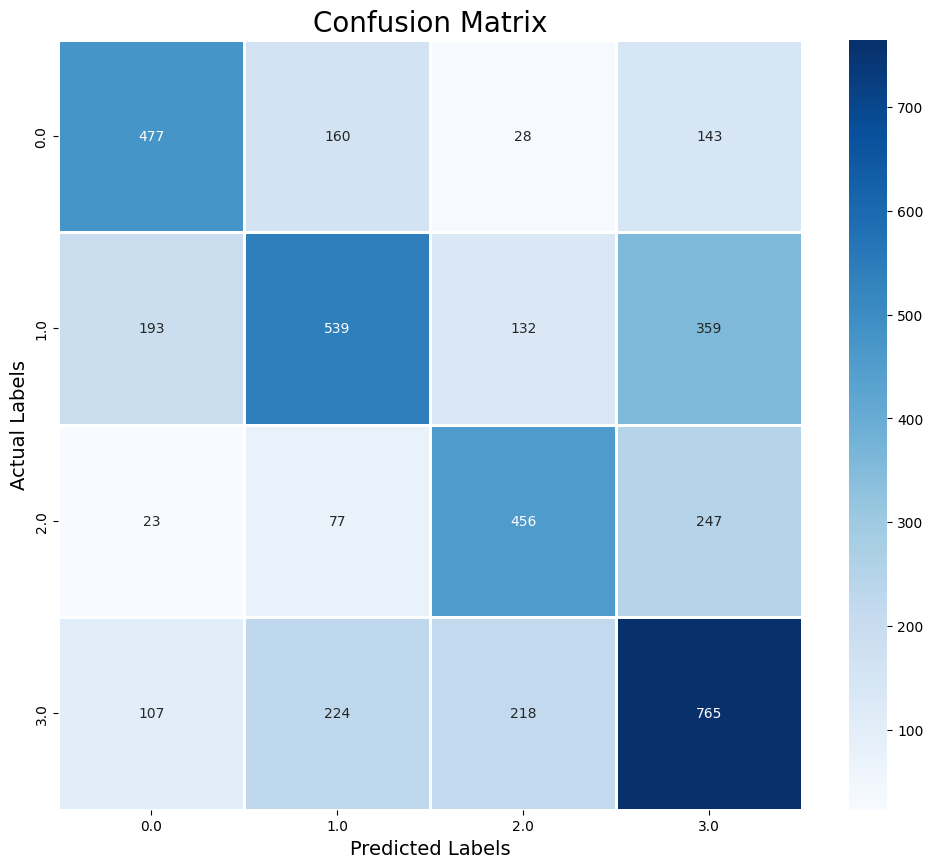

In [101]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59       808
         1.0       0.54      0.44      0.48      1223
         2.0       0.55      0.57      0.56       803
         3.0       0.51      0.58      0.54      1314

    accuracy                           0.54      4148
   macro avg       0.55      0.55      0.54      4148
weighted avg       0.54      0.54      0.54      4148



In [105]:
import torch
torch.save(model, '/kaggle/working/model_speech_emotion.pt')